In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,10760,10790,10760,10790,2410,IMP
1,1,2014-01-03,10760,10840,10670,10840,13010,IMP
2,2,2014-01-06,10870,11560,10870,11540,55630,IMP
3,3,2014-01-07,11400,11540,11330,11540,20980,IMP
4,4,2014-01-08,11370,11830,11330,11800,43410,IMP
...,...,...,...,...,...,...,...,...
2462,2462,2023-12-04,54700,55500,54400,55300,24800,IMP
2463,2463,2023-12-05,55200,55200,54600,55000,10200,IMP
2464,2464,2023-12-06,55000,55200,54900,55200,26600,IMP
2465,2465,2023-12-07,54900,55900,54900,55200,29200,IMP


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40516.605, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38170.977, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26674.731, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=26681.255, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=26676.737, Time=0.85 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=26674.657, Time=3.68 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=26677.477, Time=4.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=26675.900, Time=4.76 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=26678.732, Time=2.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=26674.262, Time=2.43 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=2.75 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1726
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -13332.131
Date:                Sat, 16 Dec 2023   AIC                          26674.262
Time:                        15:48:52   BIC                          26701.530
Sample:                             0   HQIC                         26684.349
                               - 1726                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0277      0.065      0.425      0.671      -0.100       0.155
ar.L2          0.8990      0.066     13.716      0.000       0.771       1.027
ar.L3          0.0731      0.015      4.881      0.000       0.044       0.102
ma.L1          0.9160      0.063     14.458      0.000       0.792       1.040
sigma2       2.99e+05   5443.991     54.918      0.000    2.88e+05     3.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1886.86
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(3,0,1),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1726
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -12164.132
Date:                Sat, 16 Dec 2023   AIC                          24346.263
Time:                        15:48:56   BIC                          24395.345
Sample:                             0   HQIC                         24364.420
                               - 1726                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.9507     35.230      2.042      0.041       2.902     141.000
high           0.7647      0.011     70.220      0.000       0.743       0.786
open          -0.3757      0.012    -32.266      0.000      -0.399      -0.353
low            0.6081      0.011     55.244      0.000       0.587       0.630
ar.L1         -0.0057      0.407     -0.014      0.989      -0.804       0.793
ar.L2          0.1040      0.019      5.620      0.000       0.068       0.140
ar.L3          0.0466      0.046      1.025      0.305      -0.043       0.136
ma.L1         -0.0095      0.408     -0.023      0.981      -0.809       0.790
sigma2      7.761e+04   1701.613     45.612      0.000    7.43e+04    8.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               941.15
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  441.87063191383737
MAPE:  0.7134036114518525
RMSE:  637.8447374106152

** Validate **
MAE:  414.49878950957907
MAPE:  0.7339492380814583
RMSE:  565.3000864611616


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-771:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2467    57294.210649
2468    57395.387676
2469    56569.395409
2470    56639.898324
2471    58816.976513
2472    59038.507562
2473    59130.631098
2474    57980.618619
2475    57598.276736
2476    57698.471394
2477    57593.482487
2478    56527.027139
2479    56236.321706
2480    57184.914579
2481    55797.276727
2482    56407.216320
2483    55703.832857
2484    55443.604495
2485    55182.055799
2486    56081.380492
2487    55460.579988
2488    55677.119746
2489    53606.342601
2490    54586.938116
2491    55279.609790
2492    54607.049559
2493    55041.300290
2494    54745.651487
2495    55003.239182
2496    55576.091840
Name: predicted_mean, dtype: float64


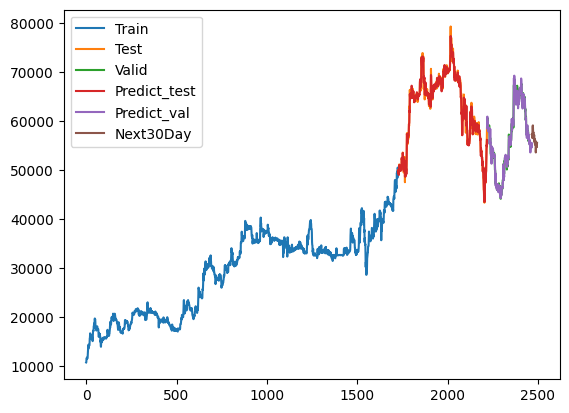

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()